# A/B Test Analysis for GloBox
by Caren Regina Maraventano

### **Table of Contents**
1. Introduction
2. Hypothesis
3. Exploratory Analysis
4. Sanity Checks: Internal Validity \
    4.1. Sample Ratio Mismatch \
    4.2. Distribution Balance
5. Metrics Analysis \
    5.1. Conversion Rate \
    5.2. Average Sales per User \
    5.3. Average Order Value 
6. Conclusions and Next Steps

## 1. Introduction

**GloBox** is an online marketplace that specializes in sourcing unique and high-quality products from around the world. **GloBox** is primarily known amongst its customer base for boutique fashion items and high-end decor products. However, their food and drink offerings have grown tremendously in the last few months, and the company wants to bring awareness to this product category to increase revenue.
The Growth team decides to run an A/B test that highlights key products in the food and drink category as a banner at the top of the website.
The setup of the A/B test is as follows:
* the experiment is only being run on the mobile website,
*  a user visits the **GloBox** main page and is randomly assigned to either the control or test group (this is the join date for the user),
* the page loads the banner if the user is assigned to the test group, and does not load the banner if the user is assigned to the control group,
* the user subsequently may or may not purchase products from the website. It could be on the same day they join the experiment, or days later. If they do make one or more purchases, this is considered a “conversion”.

## 2. Hypothesis

**H0** = If we place a banner highlighting products of the food and drink category, the percentage of purchasing customers, the  mean revenue per customer and the mean revenue per order will ***not change***, as measured by the Conversion Rate, the Average Sales per User and the Average Order Value respectively.

**H1** = If we place a banner highlighting products of the food and drink category, the percentage of purchasing customers, the  mean revenue per customer and the mean revenue per order will ***change***, as measured by the Conversion Rate, the Average Sales per User and the Average Order Value respectively.

## 3. Exploratory Analysis

In [1]:
# install and load the necessary libraries
!pip install pingouin &> /dev/null
import pingouin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
# import the dataset and quick inspection
df = pd.read_csv('/content/dataset.csv', parse_dates=['join_dt', 'dt'])
print(df.info())
print(df.sample(n=5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49082 entries, 0 to 49081
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       49082 non-null  int64         
 1   country  48435 non-null  object        
 2   gender   42200 non-null  object        
 3   group    49082 non-null  object        
 4   join_dt  49082 non-null  datetime64[ns]
 5   device   48787 non-null  object        
 6   dt       2233 non-null   datetime64[ns]
 7   spent    2233 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 3.0+ MB
None
            id country gender group    join_dt device  dt  spent
27140  1027627     CAN      F     A 2023-01-31      I NaT    NaN
22860  1023280     MEX      O     B 2023-01-31      I NaT    NaN
46368  1047251     ESP      M     A 2023-01-28      I NaT    NaN
12469  1012709     BRA      M     A 2023-01-25      A NaT    NaN
20043  1020418     USA    NaN  

In [3]:
# check for duplicates rows due to logging issues
print(len(df))
print(len(df.drop_duplicates(keep='first')))

49082
49082


In [4]:
# create a new column in where I rename group "A" to "control" and group "B" to "test"
df['group_name'] = df['group'].replace({'A': 'control', 'B': 'test'})

In [5]:
# create a 'conversion' column: 
# 1 when the customer made a purchase (only for one of their purchases)
# 0 when the customer did not make a purchase
df['conversion'] = (df['spent'].notnull() & df.groupby('id')['spent'].shift().isnull()).astype(int)
print(df.loc[df['id'] == 1020103])
print(df.sample(n=10))

            id country gender group    join_dt device         dt       spent  \
19733  1020103     USA      M     B 2023-01-29      A 2023-02-01  164.620000   
19734  1020103     USA      M     B 2023-01-29      A 2023-01-30   25.680806   

      group_name  conversion  
19733       test           1  
19734       test           0  
            id country gender group    join_dt device  dt  spent group_name  \
13605  1013860     USA      O     A 2023-01-27      I NaT    NaN    control   
31284  1031863     USA    NaN     A 2023-01-28      A NaT    NaN    control   
10575  1010782     MEX      M     B 2023-01-31      I NaT    NaN       test   
40861  1041635     USA      M     A 2023-01-26      A NaT    NaN    control   
20078  1020454     BRA      M     A 2023-01-30      A NaT    NaN    control   
27430  1027922     GBR    NaN     A 2023-01-26      A NaT    NaN    control   
2107   1002151     GBR      M     B 2023-01-30      A NaT    NaN       test   
3593   1003666     USA      O     

In [6]:
# create column 'spent_range'
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '>200']
df['spent_range'] = pd.cut(df['spent'], bins=bins, labels=labels, include_lowest=True)

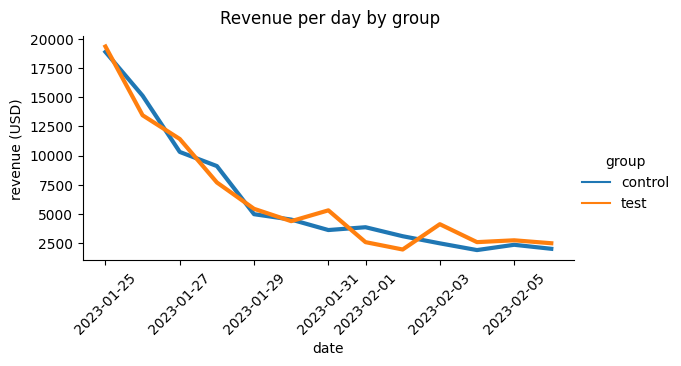

In [7]:
# revenue per day by group
g = sns.relplot(data=df, 
                x='join_dt', 
                y='spent', 
                kind='line', 
                hue='group_name', 
                hue_order=['control','test'],
                estimator=sum,
                errorbar=None,
                height=3,
                aspect=2,
                linewidth=3)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Revenue per day by group', y=1.03)
g.set(xlabel='date', ylabel='revenue (USD)')
g.legend.set_title('group')

In [8]:
# experiment duration
time = df.groupby('group')['join_dt'].agg(['min','max']).reset_index()
time['duration'] = time['max']-time['min']
time

,group,min,max,duration
0,A,2023-01-25,2023-02-06,12 days
1,B,2023-01-25,2023-02-06,12 days


## 4. Sanity Checks: Internal Validity

### 4.1. Sample Ratio Mismatch

In [9]:
# calculate the unique number of users for each group
total_users = df['id'].nunique()
control = df[df['group'] == 'A']['id'].nunique()
treatment = df[df['group'] == 'B']['id'].nunique()
print('Total unique users:', total_users, 
      '\nGroup A unique users:', control, 
      '\nGroup B unique users:', treatment)

# calculate allocation ratios per variant
control_perc = control / total_users
treatment_perc = treatment / total_users
print("Group A: {:.2f}%".format(100*control_perc))
print("Group B: {:.2f}%".format(100*treatment_perc))

# run chisquare test on observed and expected lists
observed = [ control, treatment]
expected = [ total_users/2, total_users/2 ]
chi = chisquare(observed, f_exp=expected)
if chi[1] < 0.01:
  print("SRM may be present.")
else:
  print("SRM likely not present.")

Total unique users: 48943 
Group A unique users: 24343 
Group B unique users: 24600
Group A: 49.74%
Group B: 50.26%
SRM likely not present.


### 4.2. Distribution Balance

In [10]:
# check for distribution balance by gender
print(df.groupby('group')['gender'].value_counts(normalize=True))

group  gender
A      F         0.481556
       M         0.479888
       O         0.038557
B      M         0.483457
       F         0.475822
       O         0.040720
Name: gender, dtype: float64


In [11]:
# check for distribution balance by device
print(df.groupby('group')['device'].value_counts(normalize=True))

group  device
A      A         0.621769
       I         0.378231
B      A         0.622615
       I         0.377385
Name: device, dtype: float64


In [12]:
# check for distribution balance by country
print(df.groupby('group')['country'].value_counts(normalize=True))

group  country
A      USA        0.304112
       BRA        0.199892
       MEX        0.116998
       DEU        0.079326
       TUR        0.076837
       FRA        0.063851
       GBR        0.060449
       ESP        0.041364
       CAN        0.031946
       AUS        0.025225
B      USA        0.307866
       BRA        0.190490
       MEX        0.120582
       DEU        0.080470
       TUR        0.077634
       FRA        0.064031
       GBR        0.061688
       ESP        0.041221
       CAN        0.033002
       AUS        0.023015
Name: country, dtype: float64


## 5. Metrics Analysis

### 5.1. Conversion Rate

In [13]:
print('CONVERSION RATE:')
# number of unique users per group
n = df['id'].nunique()
n_A = df[df['group'] == 'A']['id'].nunique()
n_B = df[df['group'] == 'B']['id'].nunique()
print('Total users:', n, '\nGroup A users:', n_A, '\nGroup B users:', n_B)

# number of users that made at least one purchase
purchase_A = df[df['group'] == 'A']['conversion'].sum()
purchase_B = df[df['group'] == 'B']['conversion'].sum()
print('Group A converted users:', purchase_A)
print('Group B converted users:', purchase_B)

# conversion rate per group
conv_A = purchase_A/n_A
conv_B = purchase_B/n_B
print('Group A conversion rate:', round(conv_A*100,2))
print('Group B conversion rate:', round(conv_B*100,2))

# two sample proportions z-test
n_abtest = [n_A, n_B]
purchase_abtest = [purchase_A, purchase_B]
z_stat, p_value = proportions_ztest(purchase_abtest, nobs=n_abtest)
if p_value <= 0.05:
  print(f'p-value: {p_value:.4f}, REJECT the NULL hypothesis.')
else:
  print(f'p-value: {p_value:.4f}, FAIL TO REJECT the NULL hypothesis.')

# confidence intervals
(A_low, B_low), (A_upper, B_upper) = proportion_confint(purchase_abtest, nobs=n_abtest, alpha=0.05)
print(f'Group A 95% CI: ({A_low:.4f}, {A_upper:.4f})')
print(f'Group B 95% CI: ({B_low:.4f}, {B_upper:.4f})')

# 95% CI for the difference in the conversion rate between the variants
point_estimate = conv_B-conv_A
ci_low, ci_upp = stats.norm.interval(0.95, 
                                     loc=point_estimate, 
                                     scale=np.sqrt(conv_A*(1-conv_A)/n_A + conv_B*(1-conv_B)/n_B))
print('Point estimate:', round(point_estimate*100,2))
print('Point estimate 95% CI:', (round(ci_low*100,2), round(ci_upp*100,2)))

# practical significance
threshold = 0.004
if point_estimate >= threshold and ci_low > 0:
    print("The effect is PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))
else:
    print("The effect is NOT PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))

CONVERSION RATE:
Total users: 48943 
Group A users: 24343 
Group B users: 24600
Group A converted users: 955
Group B converted users: 1139
Group A conversion rate: 3.92
Group B conversion rate: 4.63
p-value: 0.0001, REJECT the NULL hypothesis.
Group A 95% CI: (0.0368, 0.0417)
Group B 95% CI: (0.0437, 0.0489)
Point estimate: 0.71
Point estimate 95% CI: (0.35, 1.07)
The effect is PRACTICALLY SIGNIFICANT at the 0.004 level.


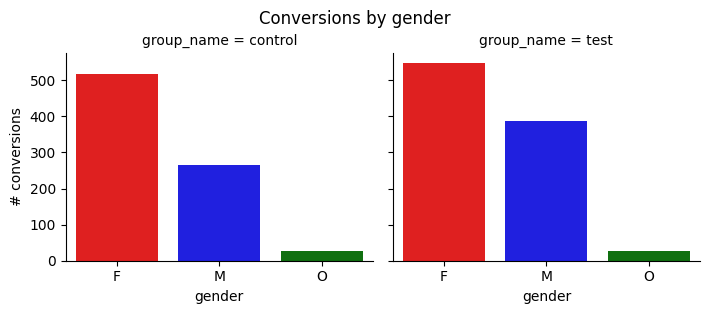

In [14]:
# conversions by gender
colors = {'M': 'blue', 'F': 'red', 'O': 'green'}
g = sns.catplot(data=df,
            x='gender',
            y='conversion',
            col='group_name',
            estimator='sum',
            col_order=['control','test'],
            order=['F','M','O'],
            kind='bar',
            height=3,
            aspect=1.2,
            errorbar=('ci', False),
            palette=colors)
g.fig.suptitle('Conversions by gender', y=1.03)
g.set(xlabel='gender', ylabel='# conversions')

### 5.2. Average Sales per User

In [15]:
# since there are separate rows for the different orders made by the same customer, I had to:
# group by id and sum the spent for each one, and fill NaN of the spent collumn with 0
df2 = df.groupby(['group', 'id'])['spent'].sum().reset_index()

# before the change 
print('Before change:')
print(df.loc[df['id'] == 1020103])
print(df.sample(n=5))

# after the change
print('After change:')
print(df2.loc[df2['id'] == 1020103])
print(df2.sample(n=5))

Before change:
            id country gender group    join_dt device         dt       spent  \
19733  1020103     USA      M     B 2023-01-29      A 2023-02-01  164.620000   
19734  1020103     USA      M     B 2023-01-29      A 2023-01-30   25.680806   

      group_name  conversion spent_range  
19733       test           1     150-200  
19734       test           0        0-50  
            id country gender group    join_dt device  dt  spent group_name  \
12239  1012476     MEX      F     B 2023-01-25      A NaT    NaN       test   
39793  1040554     ESP    NaN     A 2023-02-01      I NaT    NaN    control   
45472  1046341     USA      F     B 2023-01-30      A NaT    NaN       test   
36420  1037111     DEU      F     A 2023-01-26      A NaT    NaN    control   
34195  1034838     BRA      F     B 2023-01-28      A NaT    NaN       test   

       conversion spent_range  
12239           0         NaN  
39793           0         NaN  
45472           0         NaN  
36420       

In [16]:
print('AVERAGE SALES PER USER:')
# average sales per user by group
aspu = df2.groupby('group')['spent'].mean().round(3)
print(f'Group A: {aspu.iloc[0]:.2f}')
print(f'Group B: {aspu.iloc[1]:.2f}')

# t-test
ttest = pingouin.ttest(x = df2[df2['group'] == 'B']['spent'],
                       y = df2[df2['group'] == 'A']['spent'],
                       paired = False,
                       alternative = 'two-sided')
p_value = ttest['p-val'].item()
if p_value <= 0.05:
  print(f'p-value: {p_value:.4f}, REJECT the NULL hypothesis.')
else:
  print(f'p-value: {p_value:.4f}, FAIL TO REJECT the NULL hypothesis.')

# confidence interevals
mean_a = df2.groupby('group')['spent'].mean().iloc[0]
std_a = df2.groupby('group')['spent'].std().iloc[0]
n_a = df2.groupby('group')['spent'].count().iloc[0]
lower_A, upper_A = stats.t.interval(0.95, df=n_a-1, loc=mean_a, scale=std_a/np.sqrt(n_a))
print(f'Group A 95% CI: ({lower_A:.4f}, {upper_A:.4f})')

mean_b = df2.groupby('group')['spent'].mean().iloc[1]
std_b = df2.groupby('group')['spent'].std().iloc[1]
n_b = df2.groupby('group')['spent'].count().iloc[1]
lower_B, upper_B = stats.t.interval(0.95, df=n_b-1, loc=mean_b, scale=std_b/np.sqrt(n_b))
print(f'Group B 95% CI: ({lower_B:.4f}, {upper_B:.4f})')

# 95% CI for the difference in the average sales per user between the variants
point_estimate = mean_b-mean_a
ci_aspu = t.interval(0.95, 
                     df=n_a+n_b-2, 
                     loc=point_estimate, 
                     scale=np.sqrt((std_a**2/n_a) + (std_b**2/n_b)))
print('Point estimate:', point_estimate)
print('Point estimate 95% CI:', ci_aspu)

# practical significance
threshold = 0.3
if point_estimate >= threshold and ci_aspu[0] > 0:
    print("The effect is PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))
else:
    print("The effect is NOT PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))

AVERAGE SALES PER USER:
Group A: 3.38
Group B: 3.39
p-value: 0.9439, FAIL TO REJECT the NULL hypothesis.
Group A 95% CI: (3.0487, 3.7003)
Group B 95% CI: (3.0733, 3.7085)
Point estimate: 0.016348477956942276
Point estimate 95% CI: (-0.43864990915495816, 0.4713468650688427)
The effect is NOT PRACTICALLY SIGNIFICANT at the 0.3 level.


### 5.3. Average Order Value

In [17]:
print('AVERAGE ORDER VALUE:')
# average order value by group
aov = df.groupby('group')['spent'].sum()/df.groupby('group')['spent'].count()
revenue = df.groupby('group')['spent'].sum()
print('Group A:', aov.iloc[0].round(2))
print('Group B:', aov.iloc[1].round(2))
print('Group A revenue:', revenue.iloc[0].round())
print('Group B revenue:', revenue.iloc[1].round())

# t-test
ttest = pingouin.ttest(x = df[df['group'] == 'B']['spent'],
                       y = df[df['group'] == 'A']['spent'],
                       paired = False,
                       alternative = 'two-sided')
p_value = ttest['p-val'].item()
if p_value <= 0.05:
  print(f'p-value: {p_value:.4f}, REJECT the NULL hypothesis.')
else:
  print(f'p-value: {p_value:.4f}, FAIL TO REJECT the NULL hypothesis.')

# confidence interevals
mean_a = df.groupby('group')['spent'].mean().iloc[0]
std_a = df.groupby('group')['spent'].std().iloc[0]
n_a = df.groupby('group')['spent'].count().iloc[0]
A_low, A_upper = stats.t.interval(0.95, df=n_a-1, loc=mean_a, scale=std_a/np.sqrt(n_a))
print(f'Group A 95% CI: ({A_low:.4f}, {A_upper:.4f})')

mean_b = df.groupby('group')['spent'].mean().iloc[1]
std_b = df.groupby('group')['spent'].std().iloc[1]
n_b = df.groupby('group')['spent'].count().iloc[1]
B_low, B_upper = stats.t.interval(0.95, df=n_b-1, loc=mean_b, scale=std_b/np.sqrt(n_b))
print(f'Group B 95% CI: ({B_low:.4f}, {B_upper:.4f})')

# 95% CI for the difference in the average order value between the variants
point_estimate = mean_b-mean_a
ci_aov = t.interval(0.95, 
                     df=n_a+n_b-2, 
                     loc=point_estimate, 
                     scale=np.sqrt((std_a**2/n_a) + (std_b**2/n_b)))
print('Point estimate:', point_estimate.round(2))
print('Point estimate 95% CI:', ci_aov)

# practical significance
threshold = -4.05
if point_estimate <= threshold and ci_aov[0] < 0:
    print("The effect is PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))
else:
    print("The effect is NOT PRACTICALLY SIGNIFICANT at the {} level.".format(threshold))

AVERAGE ORDER VALUE:
Group A: 81.01
Group B: 68.43
Group A revenue: 82146.0
Group B revenue: 83415.0
p-value: 0.0015, REJECT the NULL hypothesis.
Group A 95% CI: (75.0998, 86.9237)
Group B 95% CI: (63.4034, 73.4552)
Point estimate: -12.58
Point estimate 95% CI: (-20.337576118251057, -4.827284643274375)
The effect is PRACTICALLY SIGNIFICANT at the -4.05 level.


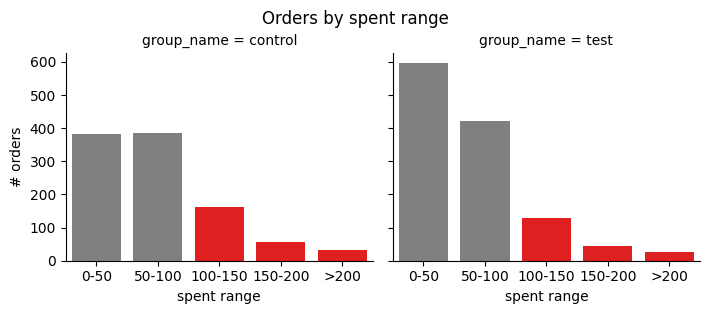

In [18]:
# orders by spent range plot
colors = {'0-50': 'gray', '50-100': 'gray', '100-150': 'red', '150-200': 'red', '>200': 'red'}
g = sns.catplot(data=df,
            x='spent_range',
            y='spent',
            col='group_name',
            estimator=len,
            col_order=['control','test'],
            kind='bar',
            height=3,
            aspect=1.2,
            palette=colors)
g.fig.suptitle('Orders by spent range', y=1.03)
g.set(xlabel='spent range', ylabel='# orders')

## 6. Conclusions and Next Steps

We use different metrics to determine the success or failure of the experiment:
- **Conversion Rate**: the test group experienced a 0.71% increase. If we launch the banner to all users, we can expect it to increase by 0.35% to 1.07%. In addition, the conversions in the test group for purchases made by men increased by 47% compared to the control group.
- **Average Sales per User**: the banner did not produce a significant change in this metric, and the small difference observed was due to chance.
- **Average Order Value**: the test group shows a decrease of 12.58 dollars. If the banner is launched to all users, we can expect it to decrease by 20.34 to 4.83 dollars. The reason for this is that the test group experienced a shift towards orders with a lower spend value, mainly within the 50 dollars spend range. While orders over 100 dollars were down 8% compared to the control group.

Although the increase in the Conversion Rate did not translate into an increase in revenue, running an A/B test with some modifications to the experiment design such as considering confounding variables (since high daily revenue values were observed in both groups in the first days of the experiment) and collecting additional information (such as the categories of the products that were purchased) will allow us to improve the accuracy of the conclusions drawn from the test and also gain a better understanding of our customers behavior.